In [ ]:
import re
import os
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

Median radius ~ 400 nm
Ln(GSD) ~ 0.262
V ~ 24.5 um3/cc
DEHS particles (refractive index = 1.45 + 1e-5i at 532 nm)

These results are for different median size cases, namely, 200 nm, 400 nm, 600 nm and 800 nm. I included another CSV file that has the average number concentration with unit of #/cc. The GSD for these experiment are not exactly known but it is most likely between 1.05 to 1.1. Note that the unit for phase function is 1/Mm 1/str.

n addition to these narrow phase function data, I included another CSV file that has the phase function for a measurement conducted for broad size distribution with median size of 400 nm and GSD 1.4. This could already be included in the current ML model as its GSD is within the training range. Note that both phase function (P11) and polarized phase function (PPF) are include in the same csv file for the broad 400 nm data.
 
 

In [ ]:
np.exp(0.262)

# Open Data

In [ ]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
directory1 = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/paper_results_gaussian_AAE/'


In [ ]:
plot_dir = directory1 + 'version13/plots/measurement_data'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

model_dir = directory1 + 'version13/model'

In [ ]:
model_name = 'invertible_model'
custom_objects = {'AdjustedRSquared': AdjustedRSquared}
kwargs = {'custom_objects': custom_objects,'compile': False}
surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

In [ ]:
data_dir = '/data/user/boiger_r/aerosol/aerosol_data/real_measurement_data_november_2021'
num_con = pd.read_csv(data_dir+"/number_concentration.csv")
phase_fun400 = pd.read_csv(data_dir+"/uNeph_PF_400nm_broad.csv")
#phase_funexp = pd.read_csv(data_dir+"/phase_function_experimental_data.csv")
#phase_funP11 = pd.read_csv(data_dir+"/phase_function_P11.csv")
#phase_funpolar = pd.read_csv(data_dir+'/polar_phase_function.csv')

In [8]:
test_datafile = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_wl-532_sc-None_qoi-ScatteringData/test_dataset.hdf5'
test_datafile ='/data/user/boiger_r/aerosol/aerosol_data/raw_data_AAE/pre_log_ts-0.2_P11_wl-532_sc-None_qoi-ScatteringData/test_dataset.hdf5'
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')

In [9]:
dvar_test

V_tot  R_median       GSD         n     k_532
75721  2315.678911  1.360143  1.422027  1.345160  0.060143
80184  1121.450456  0.871451  1.422156  1.560918  0.172217
19864  4962.553150  2.033473  1.405489  1.556752  0.179643
76699  4874.291655  0.258148  1.404925  1.331706  0.039514
92991  2536.972303  0.806500  1.444872  1.436442  0.118185
...            ...       ...       ...       ...       ...
32595  4764.529527  1.494872  1.414259  1.333477  0.047427
29313  3534.192530  1.835515  1.405211  1.468337  0.012928
37862  2015.697397  0.385029  1.430910  1.390257  0.042194
53421  3989.475902  1.355483  1.409619  1.563611  0.013500
42410  3102.600374  2.073354  1.426555  1.338385  0.098061

[20000 rows x 5 columns]

In [10]:
qoi_test

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
75721   -15.346368   -15.647405   -15.970624   -16.311292   -16.653436   
80184   -16.014276   -16.163742   -16.331920   -16.516203   -16.713155   
19864   -15.012475   -15.523168   -16.036147   -16.531054   -16.993892   
76699   -15.110576   -15.127886   -15.148264   -15.171547   -15.197773   
92991   -15.174501   -15.305256   -15.452063   -15.612544   -15.783912   
...            ...          ...          ...          ...          ...   
32595   -14.684202   -15.030477   -15.398550   -15.783268   -16.160502   
29313   -15.173373   -15.617139   -16.067307   -16.508342   -16.909186   
37862   -15.379258   -15.411835   -15.449856   -15.493067   -15.541145   
53421   -14.784675   -15.078137   -15.392046   -15.719185   -16.045682   
42410   -15.515366   -16.027250   -16.539644   -17.031266   -17.492659   

       P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
75721    -16.991183    -17.330672    -17.640897    -17.953306    -18.235696   
80184    -16.921192    -17.137610    -17.357178    -17.592391    -17.812220   
19864    -17.371364    -17.737432    -18.033515    -18.265816    -18.461357   
76699    -15.226795    -15.258587    -15.293043    -15.331595    -15.369561   
92991    -15.964517    -16.152045    -16.342427    -16.546712    -16.736172   
...             ...           ...           ...           ...           ...   
32595    -16.518349    -16.876763    -17.199644    -17.509242    -17.786276   
29313    -17.247239    -17.559565    -17.813364    -17.990783    -18.156242   
37862    -15.593900    -15.650971    -15.712164    -15.780053    -15.845553   
53421    -16.366749    -16.678024    -16.959743    -17.213962    -17.454191   
42410    -17.866221    -18.232874    -18.537709    -18.784121    -18.989895   

       ...  P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  \
75721  ...     -23.110124     -23.113011     -23.136928     -23.184647   
80184  ...     -23.459839     -23.464077     -23.464821     -23.461755   
19864  ...     -22.957258     -22.957445     -22.957538     -22.957538   
76699  ...     -20.417253     -20.405321     -20.393602     -20.382090   
92991  ...     -22.732734     -22.771907     -22.809611     -22.843529   
...    ...            ...            ...            ...            ...   
32595  ...     -22.322357     -22.292618     -22.286154     -22.309134   
29313  ...     -21.075977     -21.043402     -21.021699     -20.992087   
37862  ...     -21.247042     -21.256490     -21.263280     -21.266821   
53421  ...     -20.218619     -20.143847     -20.075221     -20.011886   
42410  ...     -24.145942     -24.140501     -24.139252     -24.143340   

       P11_0.532_170  P11_0.532_171  P11_0.532_172  P11_0.532_173  \
75721     -23.255981     -23.346580     -23.446105     -23.537277   
80184     -23.454866     -23.444477     -23.431206     -23.415891   
19864     -22.957445     -22.957258     -22.956978     -22.956511   
76699     -20.370920     -20.360152     -20.350048     -20.340592   
92991     -22.871158     -22.890708     -22.901070     -22.902218   
...              ...            ...            ...            ...   
32595     -22.364401     -22.451150     -22.561802     -22.678580   
29313     -20.964141     -20.961168     -20.984072     -21.050160   
37862     -21.266735     -21.262851     -21.255332     -21.244681   
53421     -19.957240     -19.912869     -19.875939     -19.841442   
42410     -24.152955     -24.167193     -24.183767     -24.199392   

       P11_0.532_174  P11_0.532_175  
75721     -23.598782     -23.614260  
80184     -23.399570     -23.383355  
19864     -22.956045     -22.955392  
76699     -20.332035     -20.324423  
92991     -22.895437     -22.882877  
...              ...            ...  
32595     -22.772372     -22.811788  
29313     -21.163198     -21.307003  
37862     -21.231761     -21.217743  
53421     -19.800357     -19.743550  
42410     -24.210446     -24.2143

Real measurement data

In [11]:
phase_fun400

angle    P11 [1/um]  -P12/P11
0      3.0 -1.362595e-10 -1.480170
1      4.0 -8.195502e-11 -5.891817
2      5.0  2.811317e-10 -0.051803
3      6.0  2.427819e-10  0.002813
4      7.0  2.753020e-10  0.016807
..     ...           ...       ...
169  173.0  5.147550e-12 -0.011733
170  174.0  5.379664e-12  0.003998
171  175.0  5.898060e-12 -0.014041
172  176.0  6.592036e-12 -0.009016
173  177.0  9.440054e-12  0.015246

[174 rows x 3 columns]

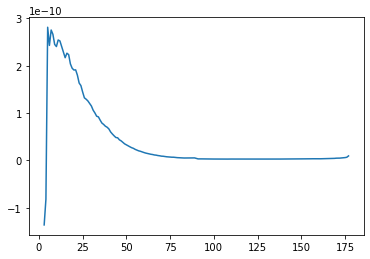

In [12]:
plt.plot(phase_fun400['angle'],phase_fun400['P11 [1/um]'])

/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


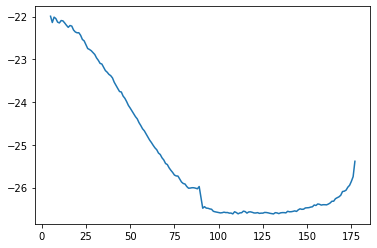

In [13]:
plt.plot(phase_fun400['angle'],np.log(phase_fun400['P11 [1/um]']))

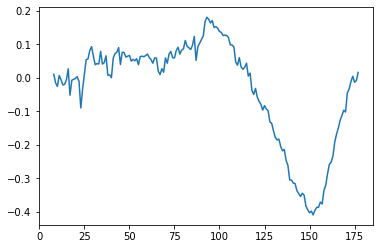

In [14]:
plt.plot(phase_fun400['angle'].iloc[5:],phase_fun400['-P12/P11'].iloc[5:])

In [15]:
phase400new_P11 = pd.DataFrame(data = phase_fun400['P11 [1/um]']).transpose()
phase400new_P12 = pd.DataFrame(data = phase_fun400['-P12/P11']).transpose()

In [16]:
listindex = []
for i in range(len(phase_fun400['angle'])):
    listindex.append("P11_0.532_"+str(int(phase_fun400['angle'].iloc[i])))
listindex2 = []
for i in range(len(phase_fun400['angle'])):
    listindex2.append("P12_0.532_"+str(int(phase_fun400['angle'].iloc[i])))
    

In [17]:

dicts = {}
keys = phase400new_P11.columns
j = 0
for i in phase400new_P11.columns:
        dicts[i] = listindex[j]
        j=j+1


dicts2 = {}
keys2 = phase400new_P12.columns
j = 0
for i in phase400new_P12.columns:
        dicts2[i] = listindex2[j]
        j=j+1

In [18]:
newpdP11 = phase400new_P11.rename(dicts,axis = 1)
newpdP12 = phase400new_P12.rename(dicts2,axis = 1)

In [19]:
newpdP12 = newpdP12.rename({'-P12/P11':'0'},axis = 0)
newpdP11 = newpdP11.rename({'P11 [1/um]':'0'},axis = 0)

In [20]:
newpdP11['P11_0.532_173'] = newpdP11['P11_0.532_176']
newpdP11['P11_0.532_174'] = newpdP11['P11_0.532_177']
newpdP11['P11_0.532_175'] = newpdP11['P11_0.532_177']

In [21]:
newpdP12

P12_0.532_3  P12_0.532_4  P12_0.532_5  P12_0.532_6  P12_0.532_7  \
0     -1.48017    -5.891817    -0.051803     0.002813     0.016807   

   P12_0.532_8  P12_0.532_9  P12_0.532_10  P12_0.532_11  P12_0.532_12  ...  \
0     0.009994    -0.015661     -0.026478      0.006169     -0.006233  ...   

   P12_0.532_168  P12_0.532_169  P12_0.532_170  P12_0.532_171  P12_0.532_172  \
0      -0.113302      -0.097383      -0.102803      -0.045366      -0.034427   

   P12_0.532_173  P12_0.532_174  P12_0.532_175  P12_0.532_176  P12_0.532_177  
0      -0.011733       0.003998      -0.014041      -0.009016       0.015246  

[1 rows x 174 columns]

In [22]:
newpdP12['P12_0.532_173'] = newpdP12['P12_0.532_176']
newpdP12['P12_0.532_174'] = newpdP12['P12_0.532_177']
newpdP12['P12_0.532_175'] = newpdP12['P12_0.532_177']

In [23]:
newpdP11_s = newpdP11.drop(['P11_0.532_3'],axis =1)

In [24]:
newpdP11_s = newpdP11.drop(['P11_0.532_3','P11_0.532_4','P11_0.532_176','P11_0.532_177'],axis = 1)

In [25]:
newpdP11_s = newpdP11_s.drop(['P11_0.532_85','P11_0.532_86','P11_0.532_87','P11_0.532_88','P11_0.532_89','P11_0.532_91','P11_0.532_92','P11_0.532_93','P11_0.532_94','P11_0.532_95'],axis =1)


In [26]:
newpdP11_s = np.log(newpdP11_s)

In [27]:
newpdP12_s = newpdP12.drop(['P12_0.532_3','P12_0.532_4','P12_0.532_176','P12_0.532_177'],axis = 1)

In [28]:
newpdP12_s =newpdP12_s.drop(['P12_0.532_85','P12_0.532_86','P12_0.532_87','P12_0.532_88','P12_0.532_89','P12_0.532_91','P12_0.532_92','P12_0.532_93','P12_0.532_94','P12_0.532_95'],axis =1)


In [29]:
newpdP12_s

P12_0.532_5  P12_0.532_6  P12_0.532_7  P12_0.532_8  P12_0.532_9  \
0    -0.051803     0.002813     0.016807     0.009994    -0.015661   

   P12_0.532_10  P12_0.532_11  P12_0.532_12  P12_0.532_13  P12_0.532_14  ...  \
0     -0.026478      0.006169     -0.006233     -0.021966     -0.020498  ...   

   P12_0.532_166  P12_0.532_167  P12_0.532_168  P12_0.532_169  P12_0.532_170  \
0      -0.150502      -0.127397      -0.113302      -0.097383      -0.102803   

   P12_0.532_171  P12_0.532_172  P12_0.532_173  P12_0.532_174  P12_0.532_175  
0      -0.045366      -0.034427      -0.009016       0.015246       0.015246  

[1 rows x 160 columns]

In [30]:
phase400new = pd.concat([newpdP11_s,newpdP12_s],axis =1)

# Reformatted Real Measurement data

In [38]:
P11_column_names = list(filter(re.compile(".*P11").match, qoi_test.columns))
P12_column_names = list(filter(re.compile(".*P12").match, qoi_test.columns))
P11_column_names

['P11_0.532_5',
 'P11_0.532_6',
 'P11_0.532_7',
 'P11_0.532_8',
 'P11_0.532_9',
 'P11_0.532_10',
 'P11_0.532_11',
 'P11_0.532_12',
 'P11_0.532_13',
 'P11_0.532_14',
 'P11_0.532_15',
 'P11_0.532_16',
 'P11_0.532_17',
 'P11_0.532_18',
 'P11_0.532_19',
 'P11_0.532_20',
 'P11_0.532_21',
 'P11_0.532_22',
 'P11_0.532_23',
 'P11_0.532_24',
 'P11_0.532_25',
 'P11_0.532_26',
 'P11_0.532_27',
 'P11_0.532_28',
 'P11_0.532_29',
 'P11_0.532_30',
 'P11_0.532_31',
 'P11_0.532_32',
 'P11_0.532_33',
 'P11_0.532_34',
 'P11_0.532_35',
 'P11_0.532_36',
 'P11_0.532_37',
 'P11_0.532_38',
 'P11_0.532_39',
 'P11_0.532_40',
 'P11_0.532_41',
 'P11_0.532_42',
 'P11_0.532_43',
 'P11_0.532_44',
 'P11_0.532_45',
 'P11_0.532_46',
 'P11_0.532_47',
 'P11_0.532_48',
 'P11_0.532_49',
 'P11_0.532_50',
 'P11_0.532_51',
 'P11_0.532_52',
 'P11_0.532_53',
 'P11_0.532_54',
 'P11_0.532_55',
 'P11_0.532_56',
 'P11_0.532_57',
 'P11_0.532_58',
 'P11_0.532_59',
 'P11_0.532_60',
 'P11_0.532_61',
 'P11_0.532_62',
 'P11_0.532_63',
 '

In [39]:
phase400new =newpdP11_s

In [40]:
from scipy.signal import savgol_filter

In [50]:
w = 53
l = 5

In [51]:
yhat_P11 = savgol_filter(phase400new[P11_column_names], w, l)
#yhat_P12 = savgol_filter(phase400new[P12_column_names], w, l)
yhat = savgol_filter(phase400new, w, l)

In [52]:
yhat_P11_1 = savgol_filter(phase400new[P11_column_names[0:80]], w, l)
yhat_P11_2 = savgol_filter(phase400new[P11_column_names[80:]], w, l)
#yhat_P12_1 = savgol_filter(phase400new[P12_column_names[0:80]], w, l)
#yhat_P12_2 = savgol_filter(phase400new[P12_column_names[80:]], w, l)


In [53]:
yhat_P11_1 =pd.DataFrame(yhat_P11_1,columns = P11_column_names[0:80])
yhat_P11_2 =pd.DataFrame(yhat_P11_2,columns = P11_column_names[80:])
#yhat_P12_1 =pd.DataFrame(yhat_P12_1,columns = P12_column_names[0:80])
#yhat_P12_2 =pd.DataFrame(yhat_P12_2,columns = P12_column_names[80:])




In [54]:
#phase400_smooth_new = pd.concat([yhat_P11_1,yhat_P11_2,yhat_P12_1,yhat_P12_2],axis =1)
phase400_smooth_new = pd.concat([yhat_P11_1,yhat_P11_2],axis =1)


In [55]:
yhat =pd.DataFrame(yhat,columns = phase400new.columns)

In [56]:
yhat_P11 =pd.DataFrame(yhat_P11,columns = P11_column_names)
#yhat_P12 =pd.DataFrame(yhat_P12,columns = P12_column_names)

In [57]:
#phase400_smooth = pd.concat([yhat_P11,yhat_P12],axis =1)
phase400_smooth = pd.concat([yhat_P11],axis =1)


In [58]:
phase400new[P11_column_names]

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0   -21.992198   -22.138857   -22.013152   -22.046841   -22.130284   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0    -22.148891    -22.092726    -22.100672    -22.149605     -22.20426  ...   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  \
0     -26.262103     -26.238466     -26.217909     -26.181366     -26.094216   

   P11_0.532_171  P11_0.532_172  P11_0.532_173  P11_0.532_174  P11_0.532_175  
0     -26.085832     -26.062446     -25.745159     -25.386059     -25.386059  

[1 rows x 160 columns]

In [59]:
phase400_smooth_new

P11_0.532_5  P11_0.532_6  P11_0.532_7  P11_0.532_8  P11_0.532_9  \
0   -22.057826   -22.056199   -22.058763    -22.06534   -22.075758   

   P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  ...  \
0    -22.089844    -22.107424     -22.12833    -22.152393    -22.179448  ...   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  \
0     -26.315406     -26.278921     -26.231229     -26.170097     -26.093058   

   P11_0.532_171  P11_0.532_172  P11_0.532_173  P11_0.532_174  P11_0.532_175  
0     -25.997408     -25.880189     -25.738183     -25.567898     -25.365564  

[1 rows x 160 columns]

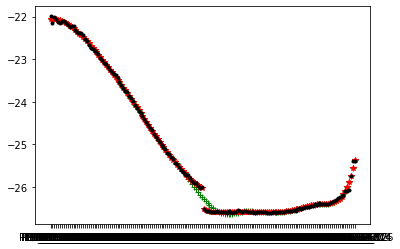

In [61]:
#plt.plot(yhat_P11[0])
#plt.plot(yhat[P11_column_names].iloc[0])
plt.plot(phase400_smooth[P11_column_names].iloc[0],'+g')
plt.plot(phase400_smooth_new[P11_column_names].iloc[0],'*r')
plt.plot(phase400new[P11_column_names].iloc[0],'.k')


In [62]:
P11_column_names[0:80]
P11_column_names[80:]

['P11_0.532_96',
 'P11_0.532_97',
 'P11_0.532_98',
 'P11_0.532_99',
 'P11_0.532_100',
 'P11_0.532_101',
 'P11_0.532_102',
 'P11_0.532_103',
 'P11_0.532_104',
 'P11_0.532_105',
 'P11_0.532_106',
 'P11_0.532_107',
 'P11_0.532_108',
 'P11_0.532_109',
 'P11_0.532_110',
 'P11_0.532_111',
 'P11_0.532_112',
 'P11_0.532_113',
 'P11_0.532_114',
 'P11_0.532_115',
 'P11_0.532_116',
 'P11_0.532_117',
 'P11_0.532_118',
 'P11_0.532_119',
 'P11_0.532_120',
 'P11_0.532_121',
 'P11_0.532_122',
 'P11_0.532_123',
 'P11_0.532_124',
 'P11_0.532_125',
 'P11_0.532_126',
 'P11_0.532_127',
 'P11_0.532_128',
 'P11_0.532_129',
 'P11_0.532_130',
 'P11_0.532_131',
 'P11_0.532_132',
 'P11_0.532_133',
 'P11_0.532_134',
 'P11_0.532_135',
 'P11_0.532_136',
 'P11_0.532_137',
 'P11_0.532_138',
 'P11_0.532_139',
 'P11_0.532_140',
 'P11_0.532_141',
 'P11_0.532_142',
 'P11_0.532_143',
 'P11_0.532_144',
 'P11_0.532_145',
 'P11_0.532_146',
 'P11_0.532_147',
 'P11_0.532_148',
 'P11_0.532_149',
 'P11_0.532_150',
 'P11_0.532_15

In [ ]:
#plt.plot(yhat_P12[0])
#plt.plot(phase400_smooth[P12_column_names].iloc[0])
#plt.plot(phase400new[P12_column_names].iloc[0])
#plt.plot(phase400_smooth_new[P12_column_names].iloc[0],'*')

# Predict dvar from measurement data

In [125]:
dvar_pred_iv = surr.sample_n_tries(phase400new.values, batch_size=128, n_tries=64)
dvar_pred_iv_smooth = surr.sample_n_tries(phase400_smooth.values, batch_size=128, n_tries=64)
dvar_pred_iv_smooth_new = surr.sample_n_tries(phase400_smooth_new.values, batch_size=128, n_tries=64)


In [126]:
dvar_pred_iv

array([[9.57126902, 0.44478296, 1.42538961, 1.36391563, 0.01957117]])

In [127]:
dvar_pred_iv = pd.DataFrame(data=dvar_pred_iv, columns=dvar_test.columns)
dvar_pred_iv

V_tot  R_median      GSD         n     k_532
0  9.571269  0.444783  1.42539  1.363916  0.019571

In [128]:
dvar_pred_iv_smooth

array([[14.3411225 ,  0.4227254 ,  1.42426453,  1.37044356,  0.02976859]])

In [129]:
dvar_pred_iv_smooth = pd.DataFrame(data=dvar_pred_iv_smooth, columns=dvar_test.columns)
dvar_pred_iv_smooth

V_tot  R_median       GSD         n     k_532
0  14.341122  0.422725  1.424265  1.370444  0.029769

In [130]:
dvar_pred_iv_smooth_new

array([[6.1903811 , 0.43605303, 1.42656504, 1.37475406, 0.02053727]])

In [132]:
dvar_pred_iv_smooth_new = pd.DataFrame(data=dvar_pred_iv_smooth_new, columns=dvar_test.columns)
dvar_pred_iv_smooth_new

V_tot  R_median       GSD         n     k_532
0  6.190381  0.436053  1.426565  1.374754  0.020537

In [ ]:
plt.plot(phase400new[P11_column_names].iloc[0])

In [ ]:
plt.plot(qoi_test[P11_column_names].loc[30040])

In [ ]:
qoi_test.describe()

# Compare to true values

In [74]:
Parameters1 = pd.DataFrame([])
n = 1.45
k = 1e-5
m = n+1j*k
sigma = np.exp(0.262)
rmean = 0.4
Vtot = 24.5
wavelength = 532
#Parameters1['RealRefractiveIndex']=[n]
#Parameters1['ImaginaryRefractiveIndex']= k
#Parameters1['Sigma']=sigma
#Parameters1['MeanRadius']=rmean
#Parameters1['VolumeConcentration']=Vtot

In [75]:
Parameters1['V_tot']=[Vtot]
Parameters1['R_median']=rmean
Parameters1['GSD']=sigma
Parameters1['n']=n
Parameters1['k_532']=k

In [76]:
Parameters1

V_tot  R_median       GSD     n    k_532
0   24.5       0.4  1.299527  1.45  0.00001

In [111]:
dvar_pred_iv

V_tot  R_median       GSD         n     k_532
0  12.796556  0.444913  1.425534  1.363001  0.019188

In [112]:
dvar_pred_iv_smooth

V_tot  R_median       GSD         n     k_532
0  10.858808  0.427465  1.424546  1.372443  0.030193

In [113]:
dvar_pred_iv_smooth_new

V_tot  R_median       GSD         n     k_532
0  7.947664  0.435626  1.426561  1.373954  0.020122

In [ ]:
# Parameter k_532 is not included in the original data set. 

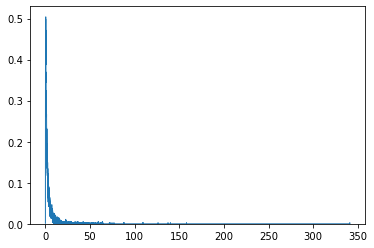

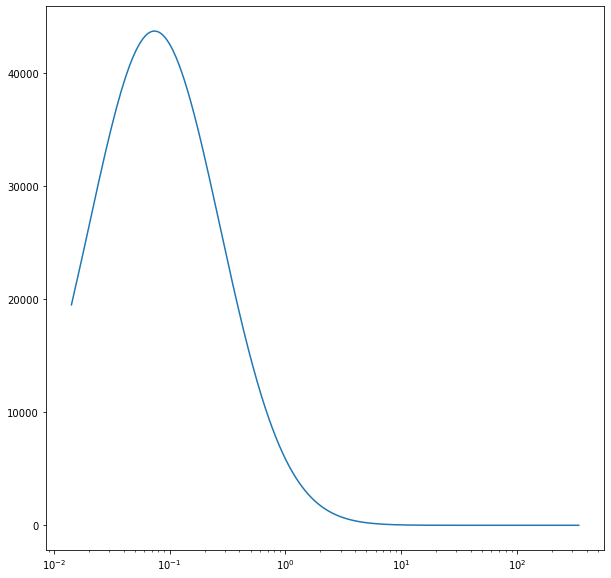

In [133]:

mu1 = Parameters1['R_median'][0]
sigma1 = Parameters1['GSD'][0]
Vtot1 = Parameters1['V_tot'][0]
s1 = np.random.lognormal(mu1, sigma1, 10000)   
count1, bins1, ignored1 = plt.hist(s1, 10000, density=True, align='mid',histtype = 'step')
x1 = np.linspace(min(bins1), max(bins1), 100000)
pdf1 = Vtot1*(np.exp(-(np.log(x1) - np.log(mu1))**2 / (2 * sigma1**2)) / (x1 * sigma1 * np.sqrt(2 * np.pi)))


fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x1,pdf1*1000)
ax.set_xscale('log')

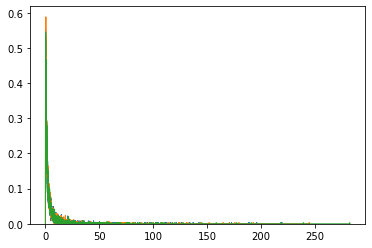

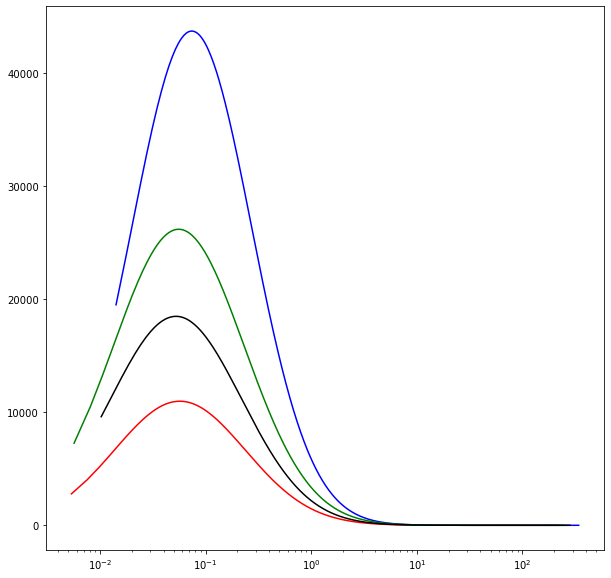

In [134]:

mu2 = dvar_pred_iv_smooth_new['R_median'][0]
sigma2 = dvar_pred_iv_smooth_new['GSD'][0]
Vtot2 = dvar_pred_iv_smooth_new['V_tot'][0]
s2 = np.random.lognormal(mu2, sigma2, 10000)   
count2, bins2, ignored2 = plt.hist(s2, 10000, density=True, align='mid',histtype = 'step')
x2 = np.linspace(min(bins2), max(bins2), 100000)
pdf2 = Vtot2*(np.exp(-(np.log(x2) - np.log(mu2))**2 / (2 * sigma2**2)) / (x2 * sigma2 * np.sqrt(2 * np.pi)))


mu3 = dvar_pred_iv_smooth['R_median'][0]
sigma3 = dvar_pred_iv_smooth['GSD'][0]
Vtot3 = dvar_pred_iv_smooth['V_tot'][0]
s3 = np.random.lognormal(mu3, sigma3, 10000)   
count3, bins3, ignored3 = plt.hist(s3, 10000, density=True, align='mid',histtype = 'step')
x3 = np.linspace(min(bins3), max(bins3), 100000)
pdf3 = Vtot3*(np.exp(-(np.log(x3) - np.log(mu3))**2 / (2 * sigma3**2)) / (x3 * sigma3 * np.sqrt(2 * np.pi)))

mu4 = dvar_pred_iv['R_median'][0]
sigma4 = dvar_pred_iv['GSD'][0]
Vtot4 = dvar_pred_iv['V_tot'][0]
s4 = np.random.lognormal(mu1, sigma4, 10000)   
count4, bins4, ignored4 = plt.hist(s4, 10000, density=True, align='mid',histtype = 'step')
x4 = np.linspace(min(bins4), max(bins4), 100000)
pdf4 = Vtot4*(np.exp(-(np.log(x4) - np.log(mu1))**2 / (2 * sigma4**2)) / (x4 * sigma4 * np.sqrt(2 * np.pi)))





fig, ax = plt.subplots(figsize = (10,10))
ax.plot(x2,pdf2*1000,'r')
ax.plot(x1,pdf1*1000,'b')
ax.plot(x3,pdf3*1000,'g')
ax.plot(x4,pdf4*1000,'k')
ax.set_xscale('log')

In [ ]:
i=0
for datalen in (0,1,2,3,4,5):
    test_marker532 = {'linewidth':0.5,'color': 'black'}
    pred_marker532 = {'marker':'o','linestyle':None,'markersize':0.8,'markerfacecolor':color1[i], 'markeredgecolor': color1[i],
             'alpha': 0.9}
    
    
    ax13.plot(x1data[datalen], y1data[datalen]*1000,**pred_marker532)
    ax13.plot(x2data[datalen], y2data[datalen]*1000,**test_marker532)

    i=i+1
    ax13.set_xscale('log')
    ax13.set_xlabel('Particle radius r [$\mu$m]',fontsize = 7)
    ax13.set_ylabel('$V(r) [\mu m^3/cm^3] $' ,fontsize = 7)
    ax13.tick_params(labelsize = 7)    
    #ax13.xaxis.set_minor_locator(AutoMinorLocator())
    x_minor = LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
    ax13.xaxis.set_minor_locator(x_minor)
    ax13.xaxis.set_minor_formatter(NullFormatter())

    ax13.set_ylim(bottom=0)
    ax13.set_xlim(left = np.min(x1data), right = np.max(x2data))
    

## Find the parameter that is closest to the measured aerosols

In [ ]:
diff_dvar = dvar_test-Parameters1.values

In [ ]:

norm_dvar = diff_dvar.apply(np.linalg.norm, axis=1)
idxmin_dvar = norm_dvar.idxmin()

dvar_test.loc[idxmin_dvar]

# Predict the phase functions from the measured parameter set

In [77]:
qoi_pred_iv_meas = surr.predict(Parameters1)

/data/user/boiger_r/python_env/aerosol_env_mie/lib/python3.8/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [78]:
Parameters2= pd.DataFrame(dvar_test.loc[idxmin_dvar].values,columns=dvar_test.columns)

NameError: name 'idxmin_dvar' is not defined

In [ ]:
qoi_pred_iv_meas_close = surr.predict(dvar_test.loc[idxmin_dvar])

In [ ]:
qoi_pred_iv_df = pd.DataFrame(qoi_pred_iv,columns = qoi_test.columns)

In [ ]:
qoi_pred_iv_df

In [ ]:
np.log((phase_fun400['P11']/(1e+9))).describe()

In [ ]:
plt.plot(phase_fun400['angle'],np.log(phase_fun400['P11']/(1e+10)),'.')

In [ ]:
qoi_test[P11_column_names].describe()

In [ ]:
qoi_test.describe()

In [ ]:
np.exp(qoi_test[P11_column_names].loc[75721])

In [ ]:
plt.plot(qoi_test[P11_column_names].loc[75721])

In [ ]:
plt.plot(qoi_pred_iv_df[P11_column_names].iloc[0])

In [ ]:
plt.plot(qoi_pred_iv_df[P12_column_names].iloc[0])

In [ ]:
plt.plot(qoi_test[P12_column_names].iloc[1000])

In [ ]:
diff_qoi_P11 = qoi_test[P11_column_names] -phase400new[P11_column_names].values


norm_df_P11 = diff_qoi_P11.apply(np.linalg.norm, axis=1)
idxmin_P11 = norm_df_P11.idxmin()

ind_P11 = qoi_test[P11_column_names].loc[idxmin_P11]

In [ ]:
ind_P11

In [ ]:
qoi_test

In [ ]:
diff_qoi_P12 = qoi_test[P12_column_names] -phase400new[P12_column_names].values


norm_df_P12 = diff_qoi_P12.apply(np.linalg.norm, axis=1)
idxmin_P12 =norm_df_P12.idxmin()
ind_P12 = qoi_test[P12_column_names].loc[idxmin_P12]

In [ ]:
diff_qoi = qoi_test -phase400new.values


norm_df = diff_qoi.apply(np.linalg.norm, axis=1)
idxmin = norm_df.idxmin()
ind = qoi_test.loc[idxmin]

In [ ]:
qoi_test.loc[idxmin]

In [ ]:
idxmin_P12

In [ ]:
idxmin_P11

In [ ]:
idxmin

In [ ]:
Parameters1

In [ ]:
dvar_test.loc[idxmin]

In [ ]:
pd.DataFrame([dvar_test.loc[idxmin]],columns = Parameters1.columns)

In [ ]:
dvar_test.loc[idxmin_P11]
pd.DataFrame([dvar_test.loc[idxmin_P11]],columns = Parameters1.columns)

In [ ]:
dvar_test.loc[idxmin_P12]

In [ ]:
plt.plot(qoi_pred_iv_df[P12_column_names].iloc[0],'b')
plt.plot(phase400new[P12_column_names].iloc[0],'r')


In [ ]:
plt.plot(qoi_pred_iv_df[P12_column_names].iloc[0],'b')
plt.plot(phase400new[P12_column_names].iloc[0],'r')
plt.plot(qoi_test[P12_column_names].loc[idxmin_P12],'g')
plt.plot(ind[P12_column_names],'k')

In [ ]:
plt.plot(qoi_pred_iv_df[P11_column_names].iloc[0],'b')
plt.plot(phase400new[P11_column_names].iloc[0],'r')
plt.plot(qoi_test[P11_column_names].loc[idxmin_P11],'g')
plt.plot(ind[P11_column_names],'k')

In [ ]:
qoi_test[P12_column_names]

In [ ]:
phase400new[P12_column_names]

In [ ]:
diff_qoi

In [ ]:
plt.plot(qoi_pred_iv_df[P12_column_names].iloc[0],'b')
plt.plot(phase400new[P12_column_names].iloc[0],'r')

In [ ]:
plt.plot(qoi_pred_iv_df[P11_column_names].iloc[0],'b')
plt.plot(phase400new[P11_column_names].iloc[0],'r')

In [ ]:
plt.plot(phase_400['angle'],phase_fun400['PPF'],'.')

In [ ]:
plt.plot(newpdP11_s.iloc[0])